<a href="https://colab.research.google.com/github/PabloNatB/Projects/blob/main/Clasificador_Se%C3%B1ales_LIGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cargar Librerías

In [ ]:
import tensorflow as tf#Librería principal
from matplotlib import pyplot as plt#Graficar
import numpy as np#Para hacer transformaciones
from tensorflow.keras.models import Sequential#Para hacer los modelos del generador y discriminador
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, MaxPooling2D#Capas de los modelos
from tensorflow.keras.optimizers import Adam#Optimizador de los modelos
from tensorflow.keras.losses import BinaryCrossentropy#Pérdida para calcular el error
from tensorflow.keras.models import Model#Para el callbach
import os#Para la dirección
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback#Hacer la clase de callback
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc
import cv2
import os

## ANÁLISIS EXPLORATORIO

In [ ]:
def calcular_estadisticas_descriptivas(ruta_directorio):
    # Lista para almacenar las estadísticas de cada imagen
    estadisticas_por_imagen = []

    lista_archivos = os.listdir(ruta_directorio)

    for archivo in lista_archivos:
        ruta_imagen = os.path.join(ruta_directorio, archivo)

        try:
            imagen = cv2.imread(ruta_imagen)

            if imagen is None:
                print(f"Error al cargar la imagen: {ruta_imagen}")
                continue

            # Convertir la imagen a escala de grises (o ajustar según sea necesario)
            imagen_grises = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

            # Calcular la media y la desviación estándar de los píxeles en la imagen
            media_pixel = np.mean(imagen_grises)
            desviacion_estandar_pixel = np.std(imagen_grises)

            # Almacenar las estadísticas en la lista
            estadisticas_por_imagen.append({
                'archivo': archivo,
                'media_pixel': media_pixel,
                'desviacion_estandar_pixel': desviacion_estandar_pixel
            })
        except Exception as e:
            print(f"Error al procesar la imagen {ruta_imagen}: {e}")

    return estadisticas_por_imagen





In [ ]:
ruta_directorio_imagenes_power = "/content/drive/MyDrive/Bedu Módulo 4/Proyecto Final/data/Power_Line"

estadisticas_imagenes_power = calcular_estadisticas_descriptivas(ruta_directorio_imagenes_power)

for estadisticas in estadisticas_imagenes_power:
    print(f"Imagen: {estadisticas['archivo']}, Media: {estadisticas['media_pixel']}, Desviación Estándar: {estadisticas['desviacion_estandar_pixel']}")

    promedio_desviacion_estandar = np.mean([est['desviacion_estandar_pixel'] for est in estadisticas_imagenes_power])
print(f"\nPromedio de la Desviación Estándar: {promedio_desviacion_estandar}")


In [ ]:
ruta_directorio_imagenes_blip = "/content/drive/MyDrive/Bedu Módulo 4/Proyecto Final/data/Blip"

estadisticas_imagenes_blip = calcular_estadisticas_descriptivas(ruta_directorio_imagenes_blip)

for estadisticas in estadisticas_imagenes_blip:
    print(f"Imagen: {estadisticas['archivo']}, Media: {estadisticas['media_pixel']}, Desviación Estándar: {estadisticas['desviacion_estandar_pixel']}")



In [ ]:
datos_Power_Line = pd.DataFrame(estadisticas_imagenes_power)
datos_Power_Line.describe()

,media_pixel,desviacion_estandar_pixel
count,1256.000000,1256.000000
mean,42.739644,14.745433
std,2.773911,4.507829
min,31.967870,5.805321
25%,40.799418,11.291679
50%,41.532447,12.946801
75%,44.974903,17.157468
max,51.567244,29.715711


In [ ]:
datos_blip= pd.DataFrame(estadisticas_imagenes_blip)
datos_blip.describe()

,media_pixel,desviacion_estandar_pixel
count,1271.000000,1271.000000
mean,43.095889,16.655694
std,3.151200,5.016746
min,29.877080,1.859464
25%,41.033478,12.968883
50%,42.246090,15.502634
75%,45.084160,19.273896
max,57.125929,37.544582


## Carga y preprocesamiento de datos

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Bedu Módulo 4/Proyecto Final/data')

Found 2527 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:

batch = data_iterator.next()

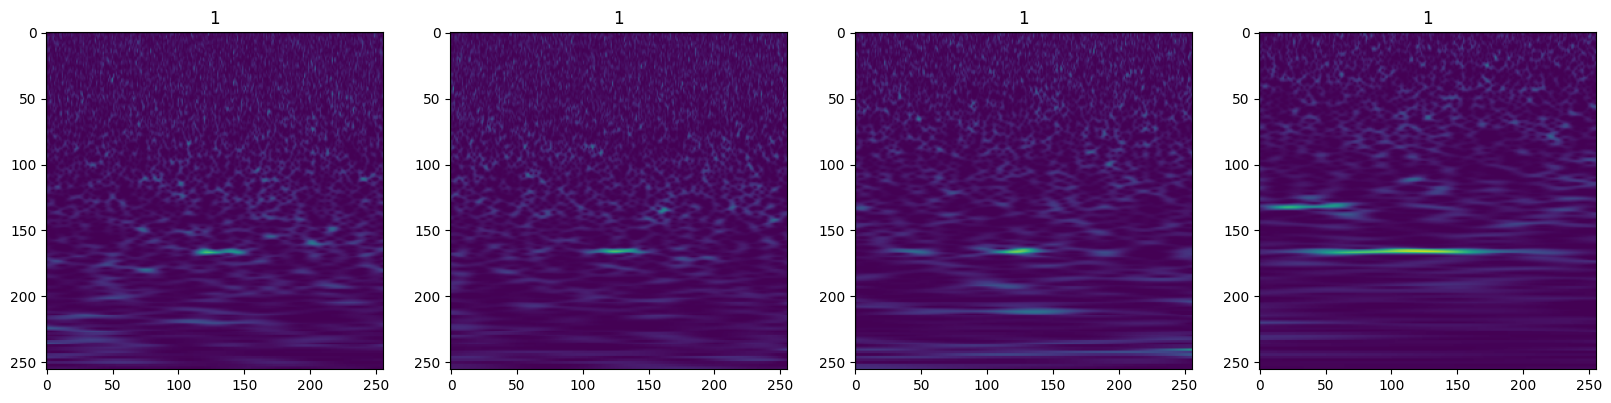

In [ ]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train_size

55

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Creación y entrenamiento de modelo

In [ ]:
def Clasificador():
    model = Sequential()#Lo definimos como secuencial

    # 1er Bloque de convolucion
    model.add(Conv2D(32, 5, input_shape = (256,256,3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(2))
    # 2do Bloque de convolucion
    model.add(Conv2D(64, 5, strides=3))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # 3er Bloque de convolucion
    model.add(Conv2D(128, 5, strides=4))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    #model.add(MaxPooling2D(2))
    # 4to Bloque de convolucion
    #model.add(Conv2D(256, 5, strides=5))
    #model.add(LeakyReLU(0.2))
    #model.add(Dropout(0.4))


    # Aplanamos y lo pasamos a evaluación, usamos la sigmoide para que la decisión sea binaria
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
modelo = Clasificador()
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 252, 252, 32)      0         
                                                                 
 dropout (Dropout)           (None, 252, 252, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 41, 64)        51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 41, 41, 64)        0         
                                                        

In [ ]:
modelo.compile(optimizer=Adam(learning_rate=0.0002), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
hist = modelo.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/5
55/55 [==============================] - 71s 1s/step - loss: 0.2498 - accuracy: 0.8955 - val_loss: 0.0273 - val_accuracy: 0.9937
Epoch 2/5
55/55 [==============================] - 11s 194ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.0070 - val_accuracy: 0.9979
Epoch 3/5
55/55 [==============================] - 11s 196ms/step - loss: 0.0091 - accuracy: 0.9960 - val_loss: 0.0053 - val_accuracy: 0.9979
Epoch 4/5
55/55 [==============================] - 11s 198ms/step - loss: 0.0093 - accuracy: 0.9955 - val_loss: 0.0066 - val_accuracy: 0.9979
Epoch 5/5
55/55 [==============================] - 11s 195ms/step - loss: 0.0046 - accuracy: 0.9972 - val_loss: 0.0037 - val_accuracy: 1.0000


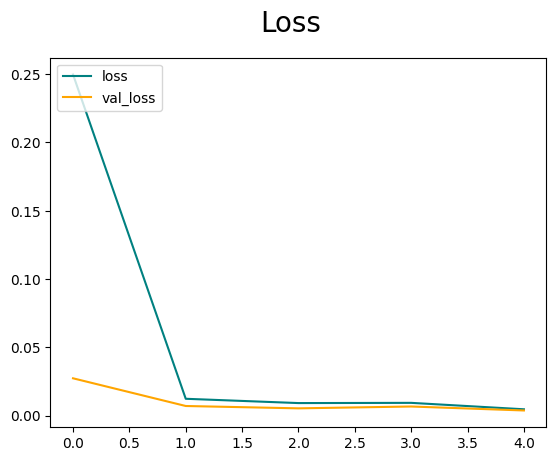

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

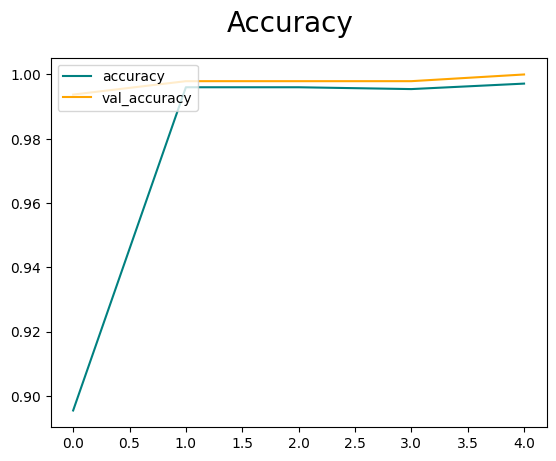

In [ ]:

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Análisis de Resultados

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = modelo.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 40ms/step


In [ ]:
print(pre.result(), re.result(), acc.result())


tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [ ]:
from sklearn import metrics

In [ ]:
y_hat=yhat.round(decimals=0, out=None).astype(int).swapaxes(0,1)
y_hat

array([[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0]])

In [ ]:
yhat_binary = np.where(yhat > 0.5, 1, 0)

In [ ]:
y

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int32)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y, yhat_binary)

cnf_matrix

array([[16,  0],
       [ 0, 16]])

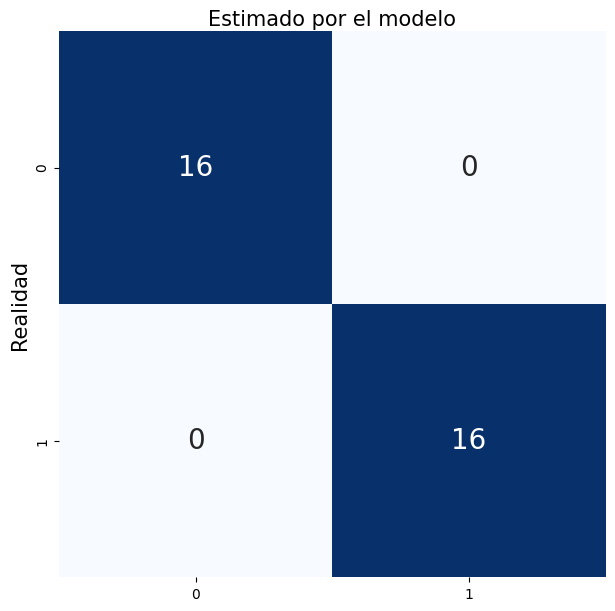

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=(6, 6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g', cbar=False, annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Realidad', fontsize=15, y=0.5)
plt.xlabel('Estimado por el modelo', fontsize=15);

In [ ]:
tn, fp, fn, tp = cnf_matrix.ravel()

print("Precision:",metrics.precision_score(y, yhat_binary))
print("Exactitud:",metrics.accuracy_score(y, yhat_binary))
print("Sensibilidad:",metrics.recall_score(y, yhat_binary))
print("Especificidad:", tn / (tn + fp))

Precision: 1.0
Exactitud: 1.0
Sensibilidad: 1.0
Especificidad: 1.0


In [ ]:
fpr, tpr, _ = roc_curve(y, yhat_binary)
roc_auc = auc(fpr, tpr)

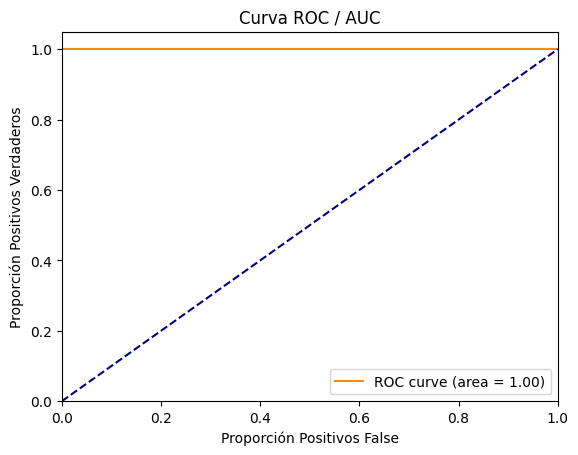

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proporción Positivos False')
plt.ylabel('Proporción Positivos Verdaderos')
plt.title('Curva ROC / AUC')
plt.legend(loc="lower right")
plt.show()